In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
from tqdm import tqdm
import json
#data procedding
from sklearn.model_selection import train_test_split
#transformers
from transformers import XLNetTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
#torch
from keras.utils import np_utils
import torch
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#set seed for reproducibility
seed=321
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
data = pd.read_json('~/environment/data/sample_1000000_2005_2018_cleaned.json')

In [5]:
data.head(1)

,index,text,stars,cleaned_text
1105058,2344352,Excellent food and customer service! My mom fo...,5,Excellent food and customer service ! My mom f...


In [6]:
data.stars.value_counts()

5    426404
4    266102
3    121561
1    102135
2     83798
Name: stars, dtype: int64

In [7]:
data['stars_reduce'] = data['stars']-1
dummy_y = np_utils.to_categorical(data.stars_reduce)
dummy_y.shape

(1000000, 5)

In [8]:
X_train, X_val,Y_train, Y_val = train_test_split(data.cleaned_text, dummy_y, test_size=0.2, 
                                                 stratify=dummy_y, random_state = seed)

In [9]:
MAX_LEN=512
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [10]:
def tokenize_xlnet(data,max_len=MAX_LEN) :
    input_ids = []
    labels = []
    
    for sent in data:
        encoded = tokenizer.encode(
            text=sent,
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN,
            padding=False
        )
        input_ids.append(encoded)
    return input_ids

In [11]:
train_ids = tokenize_xlnet(X_train, MAX_LEN)
val_ids = tokenize_xlnet(X_val, MAX_LEN)

In [12]:
#sort by length
train_samples = sorted(zip(train_ids, Y_train), key=lambda x: len(x[0]))
val_samples = sorted(zip(val_ids, Y_val), key=lambda x: len(x[0]))

In [13]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 512


In [14]:
def select_batches(samples, batch_size):
    batch_ordered_sentences = []
    batch_ordered_labels = []
    text_data = samples.copy()
    while len(text_data) > 0:
        to_take = min(batch_size, len(text_data))
        select = random.randint(0, len(text_data) - to_take)
        batch = text_data[select:(select + to_take)]
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])
        del text_data[select:select + to_take]
    # print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))
    return batch_ordered_sentences, batch_ordered_labels

In [15]:
def add_padding(batch_ordered_sentences, batch_ordered_labels):
    py_inputs = []
    py_attn_masks = []
    py_labels = []
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
        batch_padded_inputs = []
        batch_attn_masks = []

        max_size = max([len(sen) for sen in batch_inputs])
        for sen in batch_inputs:
            num_pads = max_size - len(sen)
            padded_input = sen + [tokenizer.pad_token_id]*num_pads
            attn_mask = [1] * len(sen) + [0] * num_pads
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    return py_inputs,py_attn_masks,py_labels

In [16]:
def flat_accuracy(preds, labels):
    pred = np.argmax(preds, axis=1)+1
    label = np.argmax(labels, axis=1)+1
    # print('preds_flat ', pred)
    # print('labels_flat ', label)
    return np.sum(pred == label) / len(label)

In [17]:
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='xlnet-base-cased',num_labels=5)
print('Config type:', str(type(config)), '\n')

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='xlnet-base-cased',config=config)
print('\nModel type:', str(type(model)))

Config type: <class 'transformers.models.xlnet.configuration_xlnet.XLNetConfig'> 



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a


Model type: <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'>


In [18]:
print('\nLoading model to GPU...')
device = torch.device('cuda')
print('  GPU:', torch.cuda.get_device_name(0))
desc = model.to(device)
print('    DONE.')


Loading model to GPU...
  GPU: Tesla V100-PCIE-16GB
    DONE.


In [19]:
BatchSize=8
Epochs=2
TotalSteps = len(train_ids) * Epochs
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = TotalSteps)

In [20]:
def model_train(model, epochs, batch_size, train_data, val_data):
    # store evaluation metrics
    training_stats = []
    total_t0 = time.time()

    for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train_sentences, train_labels = select_batches(train_data, batch_size)
        train_input_ids, train_attention_masks, train_type_ids = add_padding(train_sentences, train_labels)

        
        print('Training on {:,} batches...'.format(len(train_input_ids)))
        t0 = time.time()
        total_train_accuracy = 0
        total_train_loss = 0
        model.train()
        for step in tqdm(range(0, len(train_input_ids))):
            b_input_ids = train_input_ids[step].to(device)
            b_input_mask = train_attention_masks[step].to(device)
            b_labels = train_type_ids[step].to(device)
            model.zero_grad()
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels,
                           return_dict = True)
            loss = result.loss
            total_train_loss += loss.item()
            logits = result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print('logits ', logits)
            # print('label_ids ', label_ids)
            total_train_accuracy += flat_accuracy(logits, label_ids)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_input_ids)
        avg_train_accuracy = total_train_accuracy / len(train_input_ids)
        training_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
        print("")
        print("  Average training loss: {0:.4f}".format(avg_train_loss))
        print("  Average training accuracy: {0:.4f}".format(avg_train_accuracy))
        print("  Training epcoh {} took: {:}".format(epoch_i + 1, training_time))
    # ========================================
    #               Validation
    # ========================================
        val_sentences, val_labels = select_batches(val_data, batch_size)
        val_input_ids, val_attention_masks, val_type_ids = add_padding(val_sentences, val_labels)
        print('Validating on {:,} batches...'.format(len(val_input_ids)))
        t0 = time.time()
        total_val_accuracy = 0
        total_val_loss = 0
        model.eval()
        for step in tqdm(range(0, len(val_input_ids))):
            b_input_ids = val_input_ids[step].to(device)
            b_input_mask = val_attention_masks[step].to(device)
            b_labels = val_type_ids[step].to(device)
            with torch.no_grad():  
                val_result = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask, 
                                       labels=b_labels)
            logits = val_result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            loss = val_result.loss
            total_val_loss += loss.item()
            total_val_accuracy += flat_accuracy(logits, label_ids)
        avg_val_accuracy = total_val_accuracy / len(val_input_ids)
        avg_val_loss = total_val_loss / len(val_input_ids)
        val_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
        print("")
        print("  Average validation loss: {0:.4f}".format(avg_val_loss))
        print("  Average validation accuracy: {0:.4f}".format(avg_val_accuracy))
        print("  Validation epcoh {} took: {:}".format(epoch_i + 1, val_time))
        torch.save(model.state_dict(), '/home/ubuntu/environment/model/xlnet_512_2005_2018_{}'.format(epoch_i + 1))
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accuracy':avg_train_accuracy,
                'Training Time': training_time,
                'Validation Loss':avg_val_loss,
                'Validation Accuracy':avg_val_accuracy,
                'Validation Time': val_time,
            }
        )
    print("")
    print("Training complete!")
    total_time = str(datetime.timedelta(seconds = int(round(time.time() - total_t0))))
    print("Total training took: {:}".format(total_time))
    return training_stats

In [21]:
history = model_train(model, Epochs, BatchSize, train_samples, val_samples)


======== Epoch 1 / 2 ========


/tmp/ipykernel_857185/101667468.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  py_labels.append(torch.tensor(batch_labels))


Training on 100,000 batches...


100%|█████████████████████████████████| 100000/100000 [4:44:51<00:00,  5.85it/s]



  Average training loss: 0.2487
  Average training accuracy: 0.7079
  Training epcoh 1 took: 4:44:52
Validating on 25,000 batches...


100%|█████████████████████████████████████| 25000/25000 [26:05<00:00, 15.97it/s]



  Average validation loss: 0.2390
  Average validation accuracy: 0.7210
  Validation epcoh 1 took: 0:26:06

======== Epoch 2 / 2 ========
Training on 100,000 batches...


100%|█████████████████████████████████| 100000/100000 [4:50:08<00:00,  5.74it/s]



  Average training loss: 0.2335
  Average training accuracy: 0.7311
  Training epcoh 2 took: 4:50:09
Validating on 25,000 batches...


100%|█████████████████████████████████████| 25000/25000 [26:29<00:00, 15.72it/s]



  Average validation loss: 0.2417
  Average validation accuracy: 0.7253
  Validation epcoh 2 took: 0:26:30

Training complete!
Total training took: 10:28:45


In [ ]:
# torch.save(model.state_dict(), '/home/ubuntu/environment/model/xlnet_512_2005_2018')

In [22]:
with open("/home/ubuntu/environment/performance/xlnet_512_history.json", 'w') as f:
    json.dump(history, f, indent=2) 

In [23]:
history_pd = pd.DataFrame.from_records(history)
history_pd

,epoch,Training Loss,Training Accuracy,Training Time,Validation Loss,Validation Accuracy,Validation Time
0,1,0.248722,0.707856,4:44:52,0.238975,0.721035,0:26:06
1,2,0.233519,0.731080,4:50:09,0.241691,0.725325,0:26:30


Text(0.5, 1.0, 'Accuracy')

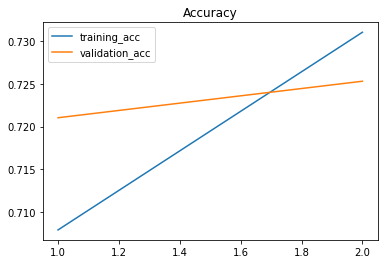

In [24]:
#plot accuracy
# plt.figure(figsize=(15, 7))
plt.plot(range(1, Epochs+1), history_pd['Training Accuracy'])
plt.plot(range(1, Epochs+1), history_pd['Validation Accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

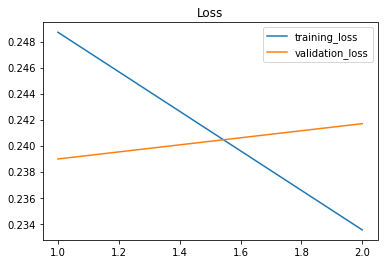

In [25]:
#plot loss
#plt.figure(figsize=(15, 7))
plt.plot(range(1, Epochs+1), history_pd['Training Loss'])
plt.plot(range(1, Epochs+1), history_pd['Validation Loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [26]:
model_loaded = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='xlnet-base-cased',config=config)
model_loaded.load_state_dict(torch.load('/home/ubuntu/environment/model/xlnet_512_2005_2018_2'))
device = torch.device('cuda')
desc = model_loaded.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [27]:
data_test= pd.read_json('~/environment/data/restaurant_review_2019_cleaned.json')

In [28]:
test_star_reduce = data_test['stars']-1
dummy_test_y = np_utils.to_categorical(test_star_reduce)

In [29]:
MAX_LEN=512
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
BatchSize=8

In [30]:
def fixed_padding(tokenizer, train_text, train_labels, batch_size, max_len):
    batches_input_ids = []
    batches_attention_masks = []
    batches_labels = []
    for i in tqdm(range(0, len(train_text), batch_size)):
        encoded_dict = tokenizer.batch_encode_plus(
            train_text[i:i+batch_size], # Batch of sentences to encode.
            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
            max_length = max_len,           # Pad & truncate all sentences.
            padding = 'max_length',     # Pad all to the `max_length` parameter.
            truncation = True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors = 'pt',     # Return pytorch tensors.
        )
        batches_input_ids.append(encoded_dict['input_ids'])
        batches_attention_masks.append(encoded_dict['attention_mask'])
        batches_labels.append(torch.tensor(train_labels[i:i+batch_size]))
    return batches_input_ids,batches_attention_masks,batches_labels

In [31]:
train_input_ids, train_attention_masks, train_type_ids = fixed_padding(tokenizer, 
                                                                    X_train,
                                                                    Y_train,
                                                                    BatchSize, MAX_LEN)

100%|██████████████████████████████████| 100000/100000 [10:59<00:00, 151.73it/s]


In [32]:
val_input_ids, val_attention_masks, val_type_ids = fixed_padding(tokenizer, 
                                                                    X_val,
                                                                    Y_val,
                                                                    BatchSize, MAX_LEN)

100%|████████████████████████████████████| 25000/25000 [02:52<00:00, 144.53it/s]


In [33]:
test_input_ids, test_attention_masks, test_type_ids = fixed_padding(tokenizer, 
                                                                    data_test.cleaned_text,
                                                                    dummy_test_y,
                                                                    BatchSize, MAX_LEN)

100%|████████████████████████████████████| 65575/65575 [06:56<00:00, 157.57it/s]


In [34]:
def model_predict(model, batch_size, test_input_ids, test_attention_masks, test_type_ids):
    t0 = time.time()
    predictions , true_labels = [], []
    
    print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
    model.eval()
    for step in tqdm(range(0, len(test_input_ids))):
        b_input_ids = test_input_ids[step].to(device)
        b_input_mask = test_attention_masks[step].to(device)
        b_labels = test_type_ids[step].to(device)
        with torch.no_grad():  
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    test_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
    print("Total testing took: {:}".format(test_time))
    return predictions, true_labels

In [35]:
train_evals, train_stars = model_predict(model_loaded, BatchSize, train_input_ids, train_attention_masks, train_type_ids)

Predicting labels for 100,000 test sentences...


100%|█████████████████████████████████| 100000/100000 [7:39:38<00:00,  3.63it/s]

Total testing took: 7:39:38


In [36]:
train_eval = np.argmax(np.concatenate(train_evals, axis=0), axis = 1)+1
train_star = np.argmax(np.concatenate(train_stars, axis=0), axis = 1)+1

In [37]:
confusion_matrix(train_star, train_eval)

array([[ 70811,   9436,   1061,    117,    283],
       [ 16160,  38314,  11519,    693,    352],
       [  2199,  12450,  59259,  20325,   3016],
       [   369,    674,  10613, 119784,  81442],
       [   424,    146,    733,  25235, 314585]])

In [38]:
print(classification_report(train_star, train_eval, digits = 4))

              precision    recall  f1-score   support

           1     0.7871    0.8666    0.8250     81708
           2     0.6279    0.5715    0.5984     67038
           3     0.7124    0.6094    0.6568     97249
           4     0.7209    0.5627    0.6320    212882
           5     0.7871    0.9222    0.8493    341123

    accuracy                         0.7534    800000
   macro avg     0.7271    0.7065    0.7123    800000
weighted avg     0.7471    0.7534    0.7446    800000



In [39]:
val_evals, val_stars = model_predict(model_loaded, BatchSize, val_input_ids, val_attention_masks, val_type_ids)

Predicting labels for 25,000 test sentences...


100%|███████████████████████████████████| 25000/25000 [1:55:30<00:00,  3.61it/s]

Total testing took: 1:55:30


In [40]:
val_eval = np.argmax(np.concatenate(val_evals, axis=0), axis = 1)+1
val_star = np.argmax(np.concatenate(val_stars, axis=0), axis = 1)+1

In [41]:
confusion_matrix(val_star, val_eval)

array([[17218,  2691,   351,    50,   117],
       [ 4512,  8627,  3269,   234,   118],
       [  668,  3534, 13770,  5421,   919],
       [  148,   177,  3194, 28112, 21589],
       [  162,    68,   266,  7450, 77335]])

In [42]:
print(classification_report(val_star, val_eval, digits = 4))

              precision    recall  f1-score   support

           1     0.7582    0.8429    0.7983     20427
           2     0.5714    0.5147    0.5416     16760
           3     0.6604    0.5664    0.6098     24312
           4     0.6812    0.5282    0.5950     53220
           5     0.7727    0.9068    0.8344     85281

    accuracy                         0.7253    200000
   macro avg     0.6888    0.6718    0.6758    200000
weighted avg     0.7164    0.7253    0.7152    200000



In [43]:
preds, stars = model_predict(model_loaded, BatchSize, test_input_ids, test_attention_masks, test_type_ids)

Predicting labels for 65,575 test sentences...


100%|███████████████████████████████████| 65575/65575 [5:01:36<00:00,  3.62it/s]

Total testing took: 5:01:36


In [44]:
pred = np.argmax(np.concatenate(preds, axis=0), axis = 1)+1
star = np.argmax(np.concatenate(stars, axis=0), axis = 1)+1

In [45]:
confusion_matrix(data_test['stars'], pred)

array([[ 59262,   7452,   1106,    151,    433],
       [ 12978,  20244,   6055,    415,    261],
       [  2498,  10226,  28506,   7996,   1422],
       [   345,    605,   8532,  54913,  36921],
       [   480,    188,    812,  21597, 241195]])

In [46]:
print(classification_report(data_test['stars'], pred, digits=4))

              precision    recall  f1-score   support

           1     0.7843    0.8664    0.8233     68404
           2     0.5229    0.5067    0.5147     39953
           3     0.6333    0.5628    0.5960     50648
           4     0.6455    0.5420    0.5892    101316
           5     0.8607    0.9127    0.8859    264272

    accuracy                         0.7703    524593
   macro avg     0.6893    0.6781    0.6818    524593
weighted avg     0.7615    0.7703    0.7642    524593



In [47]:
data_test['stars_xlnet_512'] = pred

In [48]:
data_test.to_json('~/environment/data/restaurant_review_2019_cleaned_xlnet_512_prediction.json')

In [ ]:
'''
padded_lengths = []

for batch in train_input_ids:
    for s in batch:
        padded_lengths.append(len(s))
smart_token_count = np.sum(padded_lengths)

fixed_token_count = len(X_train) * MAX_LEN
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))
'''